# Perform decoding and encoding
Decode ROI and continuous images into text and encode text into continuous image.

NOTE: Continuous image decoding still has some problems.

In [1]:
%matplotlib inline
from gclda.model import Model
from gclda.decode import Decoder
from gclda.utils import plot_brain

In [2]:
%%time
# Load example model and initialize decoder
model = Model.load('gclda_results/results.pkl')
decoder = Decoder(model)

model.display_model_summary()

--- Model Summary ---
 Current State:
	 Current Iteration   = 50
	 Initialization Seed = 1
	 Current Log-Likely  = -15308887.4342
 Model Hyper-Parameters:
	 Symmetric = True
	 n_topics  = 400
	 n_regions = 2
	 alpha     = 0.100
	 beta      = 0.010
	 gamma     = 0.010
	 delta     = 1.000
	 roi_size  = 50.000
	 dobs      = 25.0
 Model Training-Data Information:
	 Dataset Label                 = 20170728
	 Word-Tokens (n_word_tokens)   = 1033977
	 Peak-Tokens (n_peak_tokens)   = 413292
	 Word-Types (n_word_labels)    = 2476
	 Documents (n_docs)            = 11404
	 Peak-Dimensions (n_peak_dims) = 3
CPU times: user 45.2 s, sys: 1.67 s, total: 46.8 s
Wall time: 48.9 s


## Decode a region of interest

In [3]:
%%time
roi_file = 'data/fusiform.nii.gz'
fusiform_df = decoder.decode_roi(roi_file)
fusiform_df = fusiform_df.sort_values(by='Weight', ascending=False)
print(fusiform_df.head())

            Weight
Term              
face      0.024859
faces     0.016375
fusiform  0.010752
memory    0.010081
temporal  0.009195
CPU times: user 19.6 s, sys: 26.8 s, total: 46.4 s
Wall time: 41.7 s


## Decode a continuous image
For some reason, the seemingly relevant features actually have the lowest weights, which is why `ascending` is currently set to `True`. We need to look into why this is happening. Also, when we decode `pFgA`, `pAgF`, `pFgA_given_pF=0.50`, or `pAgF_given_pF=0.50` images, we don't even get that pattern.

In [4]:
%%time
continuous_file = 'data/faces_specificity_z.nii.gz'
faces_df = decoder.decode_continuous(continuous_file)
faces_df = faces_df.sort_values(by='Weight', ascending=True)
print(faces_df.head())

            Weight
Term              
face     -0.025842
amygdala -0.023971
faces    -0.019190
temporal -0.017930
visual   -0.016946
CPU times: user 18.6 s, sys: 57.5 s, total: 1min 16s
Wall time: 44.2 s


## Encode text into an image

CPU times: user 21.1 s, sys: 1min, total: 1min 21s
Wall time: 52.3 s


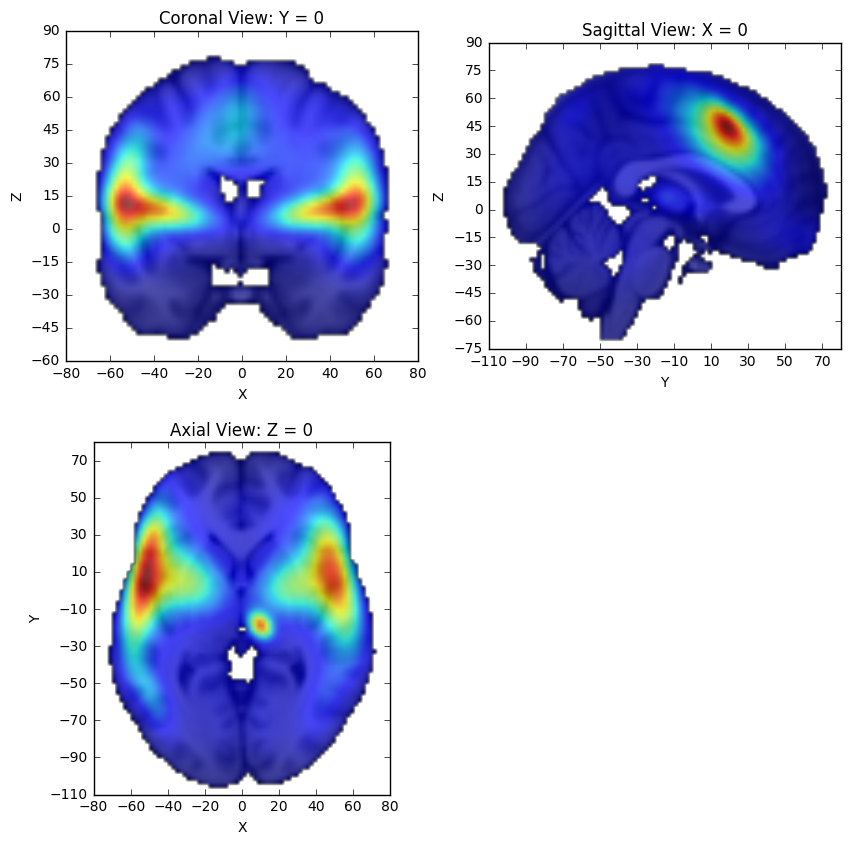

In [5]:
%%time
text = 'painful stimulation during a language task'
text_image = decoder.encode(text)
underlay = model.dataset.masker.volume
fig = plot_brain(text_image, underlay)